In [250]:
# ! pip install --upgrade pillow
# ! pip install opencv-python


In [251]:
# import tensorflow as tf
# print("TensorFlow version:", tf.__version__)

In [252]:
import tensorflow as tf
import glob 
from tkinter import Tcl
from keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,Conv2DTranspose,LeakyReLU,Activation,Concatenate
from tensorflow.keras.layers import Input, Conv3D, Activation, Add, LeakyReLU,Conv3DTranspose
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, LeakyReLU, Activation, Concatenate, GlobalAveragePooling2D, MaxPool2D, Reshape, Dense, Multiply, UpSampling2D

import time
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from PIL import Image, ImageSequence
from PIL import Image, ImageOps
import imageio
from skimage.metrics import structural_similarity as compare_ssim
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
import os
from PIL import Image
import shutil
import os

In [292]:
A = 'FLAIR'
B = 'T2'
nii_input_sample='t2f'

In [293]:
restor_ckp_path= r"D:\FCAI\Year (4)\Graduation_Project\Best_ckp"
input_nii=f"D:\FCAI\Year (4)\Graduation_Project\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData\BraTS-GLI-00016-000\BraTS-GLI-00016-000-{nii_input_sample}.nii.gz"


In [294]:
nii_real_sample='t2w'
input_nii_real=f"D:\FCAI\Year (4)\Graduation_Project\GIF_Test\sample\BraTS-GLI-00016-000\BraTS-GLI-00016-000-{nii_real_sample}.nii.gz"

In [295]:
path = r"D:\FCAI\Year (4)\Graduation_Project\Final_prediction"
os.makedirs(path, exist_ok=True)
Path(os.path.join(path, f"{A} TO {B}")).mkdir(parents=True, exist_ok=True)
model_path = os.path.join(path, f"{A} TO {B}")

Path(os.path.join(model_path, f"Converted_png_from_nii")).mkdir(parents=True, exist_ok=True)
Converted_png_from_nii_path = os.path.join(model_path, "Converted_png_from_nii")

Path(os.path.join(model_path, f"crop_black_boundary")).mkdir(parents=True, exist_ok=True)
crop_black_boundary_path = os.path.join(model_path, "crop_black_boundary")

Path(os.path.join(model_path, f"Generated_results")).mkdir(parents=True, exist_ok=True)
Generated_results_path = os.path.join(model_path, "Generated_results")

Path(os.path.join(model_path, f"Generated_resized_results")).mkdir(parents=True, exist_ok=True)
Generated_resized_results_path = os.path.join(model_path, "Generated_resized_results")

Path(os.path.join(model_path, f"Generated_results_Final")).mkdir(parents=True, exist_ok=True)
Generated_results_Final_path = os.path.join(model_path, "Generated_results_Final")

Path(os.path.join(model_path, f"Generated_results_nii")).mkdir(parents=True, exist_ok=True)
Generated_results_nii_path = os.path.join(model_path, "Generated_results_nii")

Path(os.path.join(model_path, f"Add_black_images")).mkdir(parents=True, exist_ok=True)
Add_black_images_path = os.path.join(model_path, "Add_black_images")



## **3. Redifine Models**

## 3.1 Genrator

In [296]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        # Create trainable parameters gamma and beta
        self.gamma = self.add_weight(shape=(input_shape[-1],),
                                     initializer='ones',
                                     trainable=True,
                                     name='gamma')
        self.beta = self.add_weight(shape=(input_shape[-1],),
                                    initializer='zeros',
                                    trainable=True,
                                    name='beta')
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        # Compute the mean and variance along the spatial dimensions
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape


In [297]:
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = InstanceNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = InstanceNormalization()(x)
    x = L.Activation("relu")(x)

    return x


def se_block(x, num_filters, ratio=8):
    se_shape = (1, 1, num_filters)
    se = L.GlobalAveragePooling2D()(x)
    se = L.Reshape(se_shape)(se)
    se = L.Dense(num_filters // ratio, activation="relu", use_bias=False)(se)
    se = L.Dense(num_filters, activation="sigmoid", use_bias=False)(se)
    se = L.Reshape(se_shape)(se)
    x = L.Multiply()([x, se])
    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    x = se_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    x = se_block(x, num_filters)
    return x

def squeeze_attention_unet(input_shape=(256, 256, 3)):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)


    b1 = conv_block(p4, 1024)
    b1 = se_block(b1, 1024)
    


    """ Decoder """
    d =  decoder_block(b1, s4, 512)
    d1 = decoder_block(d, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = L.Conv2D(3, (1, 1), activation='tanh')(d3)

    """ Model """
    
    model = Model(inputs, outputs, name="Squeeze-Attention-UNET")
    return model


In [298]:
generator_g = squeeze_attention_unet()

## 3.2 Discriminator

In [299]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [300]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp
    down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(3, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [301]:
discriminator_x = discriminator()


In [302]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5 ) # , beta_1=0.5

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5 ) # , beta_1=0.5

In [303]:
checkpoint = tf.train.Checkpoint(generator_g=generator_g,
                           
                           discriminator_x=discriminator_x,
                           
                           generator_g_optimizer=generator_g_optimizer,
                           
                           discriminator_x_optimizer=discriminator_x_optimizer)
# Set up the checkpoint manager
manager = tf.train.CheckpointManager(checkpoint,f"{restor_ckp_path}\{A} to {B}", max_to_keep=5)

ckpt_restore_path = manager.latest_checkpoint
if ckpt_restore_path:
    checkpoint.restore(ckpt_restore_path)
    print(f"Restored from {ckpt_restore_path}")
else:
    print("Initializing from scratch.")


Restored from D:\FCAI\Year (4)\Graduation_Project\Best_ckp\FLAIR to T2\ckpt-79


In [325]:
import pathlib
from pathlib import Path

data_dir_flair = pathlib.Path(r"C:\Users\joseph\Desktop\one_flair_image")
data_dir_t2 = pathlib.Path(r"C:\Users\joseph\Desktop\one_t2_image")
data_dir_t2_real = pathlib.Path(r"C:\Users\joseph\Desktop\one_real_t2")


print("T2 MRI images: ",len(list(data_dir_t2.glob('*B*.png'))))
print("FLAIR MRI images: ",len(list(data_dir_flair.glob('*B*.png'))))

T2 MRI images:  0
FLAIR MRI images:  0


In [326]:

BUFFER_SIZE = 14920
BATCH_SIZE = 8
EPOCHS = 200
img_height = 256
img_width = 256

In [327]:
# T2 MRI images Test set
tr2_test = tf.keras.preprocessing.image_dataset_from_directory(
                              data_dir_t2,
                              seed=123,
                              #validation_split = 0.06,
                              #subset = 'validation',
                              labels=None,
                              shuffle = True,
                              image_size=(img_height, img_width),
                              batch_size=1)

Found 1 files belonging to 1 classes.


In [328]:
flair_test = tf.keras.preprocessing.image_dataset_from_directory(
                              data_dir_flair,
                              seed=123,
                              #validation_split = 0.06,
                              #subset = 'validation',
                              labels=None,
                              shuffle = True,
                              image_size=(img_height, img_width),
                              batch_size=1)

Found 1 files belonging to 1 classes.


In [329]:
t2_real = tf.keras.preprocessing.image_dataset_from_directory(
                              data_dir_t2_real,
                              seed=123,
                              #validation_split = 0.06,
                              #subset = 'validation',
                              labels=None,
                              shuffle = True,
                              image_size=(img_height, img_width),
                              batch_size=1)

Found 1 files belonging to 1 classes.


In [330]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
#tr2_train = tr2_train.cache().prefetch(buffer_size=AUTOTUNE)
tr2_test = tr2_test.cache().prefetch(buffer_size=AUTOTUNE)
t2_real = t2_real.cache().prefetch(buffer_size=AUTOTUNE)
#flair_train = flair_train.cache().prefetch(buffer_size=AUTOTUNE)
flair_test = flair_test.cache().prefetch(buffer_size=AUTOTUNE)

In [331]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = (image/127.5)-1
    return image

In [332]:
# process both classes of MRI images
#tr2_train = tr2_train.map(lambda x: (normalize(x)))
#flair_train = flair_train.map(lambda x: (normalize(x)))
tr2_test = tr2_test.map(lambda x: (normalize(x)))
flair_test = flair_test.map(lambda x: (normalize(x)))
t2_real = t2_real.map(lambda x: (normalize(x)))

In [333]:
sample_tr2 = next(iter(tr2_test))
sample_flair = next(iter(flair_test))
sample_real_t2 = next(iter(t2_real))

print(sample_tr2.shape)

(1, 256, 256, 3)


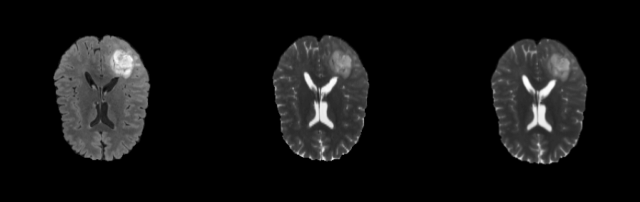

In [334]:
#to_t2 = generator_g(sample_flair)
plt.figure(figsize=(8, 8), facecolor='black')
contrast = 8

imgs = [sample_flair, sample_real_t2, sample_tr2]

for i in range(len(imgs)):
    plt.subplot(1, 3, i + 1)
    plt.gca().set_facecolor('black')  # Set subplot background to black
    img = imgs[i][0].numpy()[:, :, 0]
    img_rotated = np.rot90(img)  # Rotate the image 90 degrees counterclockwise
    if i % 2 == 0:
        plt.imshow(img_rotated * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(img_rotated * 0.5 * contrast + 0.5, cmap='gray')
    plt.axis('off')  # Hide axis for cleaner look

plt.show()

In [265]:
def clear_folder(folder_path):
    # List all files in the folder
    files = glob.glob(os.path.join(folder_path, "*.png"))
    # Delete each file
    for f in files:
        os.remove(f)

In [266]:
def nii_to_png(input_file, output_dir):
    # Load the NIfTI file
    img = nib.load(input_file)
    data = img.get_fdata()

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    else:
        # Delete existing PNG files in the output directory
        existing_png_files = [f for f in os.listdir(output_dir) if f.endswith('.png')]
        for png_file in existing_png_files:
            os.remove(os.path.join(output_dir, png_file))
        #print(f"Deleted {len(existing_png_files)} existing PNG files in {output_dir}")

    # Iterate over the slices in the 3rd dimension
    for i in range(data.shape[2]):
        slice_data = data[:, :, i]

        # Normalize the slice data to 0-255
        slice_data = (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data)) * 255
        slice_data = slice_data.astype(np.uint8)

        output_path = os.path.join(output_dir, f'slice_{i:03d}.png')
        plt.imsave(output_path, slice_data, cmap='gray')

        #print(f'Saved {output_path}')
    print("Phase 1 Done")

input_file = input_nii
output_dir = Converted_png_from_nii_path
clear_folder(output_dir)
nii_to_png(input_file, output_dir)


C:\Users\joseph\AppData\Local\Temp\ipykernel_10980\1542534308.py:21: RuntimeWarning: invalid value encountered in divide
  slice_data = (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data)) * 255
C:\Users\joseph\AppData\Local\Temp\ipykernel_10980\1542534308.py:22: RuntimeWarning: invalid value encountered in cast
  slice_data = slice_data.astype(np.uint8)


Phase 1 Done


In [267]:
def crop_black_space(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Find all non-black pixels
    coords = cv2.findNonZero(gray)
    
    # Check if there are any non-black pixels found
    if coords is None:
        # If no non-black pixels are found, the image is considered completely black
        #print("Image is completely black.")
        return None
    
    # Create a bounding box around the non-black pixels
    x, y, w, h = cv2.boundingRect(coords)
    
    # Check if the bounding box has a valid size
    if w == 0 or h == 0:
        #print("Invalid bounding box size, returning original image")
        return image
    
    # Crop the image to the bounding box
    cropped = image[y:y+h, x:x+w]
    return cropped

def process_images(input_folder, output_folder):
    # # Create the output folder if it doesn't exist
    # if not os.path.exists(output_folder):
    #     os.makedirs(output_folder)

    # Iterate through all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            # Read the image
            img_path = os.path.join(input_folder, filename)
            image = cv2.imread(img_path)
            
            # Check if the image was successfully loaded
            if image is None:
                #print(f"Warning: Could not read image {img_path}. Skipping.")
                continue
            
            # Crop the black space
            cropped_image = crop_black_space(image)
            
            # If the image is completely black, delete it
            if cropped_image is None:
                #os.remove(img_path)
                #print(f"Deleted completely black image {img_path}.")
                continue
            
            # Save the cropped image
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, cropped_image)

    print("Phase 2 Done")



input_folder = Converted_png_from_nii_path
output_folder = crop_black_boundary_path
clear_folder(output_folder)
process_images(input_folder, output_folder)


Phase 2 Done


In [268]:
def generate_single_images_GIF(img_input, model, order, generated_results_path):
    # Clear the folder before saving new images

    # Generate model prediction
    prediction = model(img_input)
    # Extract the specific slice and rotate
    pred_vol = prediction[0, :, :, 0].numpy().copy()

    # Create a figure for displaying the image
    plt.figure(figsize=(10, 6))
    display_list = [pred_vol] 
    for i in range(1):
        plt.subplot(1, 1, i+1)
        plt.imshow(display_list[i]*0.5+0.5, cmap='gray')
        plt.axis('off')
        
        # Format the save path to ensure filename is in the desired format
        slice_number = order + i + 6  # Calculate slice number based on order and offset
        save_path = f"{generated_results_path}\\slice_{slice_number:03d}.png"
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, transparent=True)
        plt.close()

    return pred_vol

In [269]:
def normalize(image):
    image = (image/127.5)-1
    return image

In [270]:
def Generat ():
    Gen_A = tf.keras.preprocessing.image_dataset_from_directory(
                              crop_black_boundary_path,
                              seed=123,
                              labels=None,
                              image_size=(256, 256),
                              batch_size=1,
                              shuffle = False)

    Gen_B = tf.keras.preprocessing.image_dataset_from_directory(
                                crop_black_boundary_path,
                                seed=123,
                                labels=None,
                                image_size=(256, 256),
                                batch_size=1,
                                shuffle = False)
    
    Gen_A = Gen_A.map(lambda x: (normalize(x)))
    Gen_B = Gen_B.map(lambda x: (normalize(x)))

    order_2 = 0
    clear_folder(Generated_results_path)
    for image_x, image_y in tf.data.Dataset.zip((Gen_A, Gen_B)):
        generate_single_images_GIF(image_x, generator_g, order_2,Generated_results_path)
        order_2 = order_2 + 1
    
    print("Phase 3 Done")
    
Generat ()

Found 138 files belonging to 1 classes.
Found 138 files belonging to 1 classes.
Phase 3 Done


In [271]:
def resize_images(source_dir, target_dir, output_dir):
    # Get the list of image files from both directories
    source_images = sorted([f for f in os.listdir(source_dir) if f.endswith('.png')])
    target_images = sorted([f for f in os.listdir(target_dir) if f.endswith('.png')])
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    for source_img_name, target_img_name in zip(source_images, target_images):
        # Open the source image and get its size
        source_img_path = os.path.join(source_dir, source_img_name)
        source_img = Image.open(source_img_path)
        source_size = source_img.size
        
        # Open the target image
        target_img_path = os.path.join(target_dir, target_img_name)
        target_img = Image.open(target_img_path)
        
        # Resize the target image to match the source image's size
        resized_target_img = target_img.resize(source_size, Image.LANCZOS)
        
        # Save the resized image to the output directory
        output_img_path = os.path.join(output_dir, target_img_name)
        resized_target_img.save(output_img_path)
        
        #print(f'Resized {target_img_name} to {source_size} and saved to {output_img_path}')
    print("Phase 4 Done")

# Define the directories
source_directory = crop_black_boundary_path
target_directory = Generated_results_path
output_directory = Generated_resized_results_path

# Run the resizing function
clear_folder(Generated_resized_results_path)
resize_images(source_directory, target_directory, output_directory)

Phase 4 Done


In [272]:
import os
from PIL import Image, ImageOps

def add_border(input_image_path, output_image_path, desired_size=240):
    image = Image.open(input_image_path)
    
    # Calculate the border sizes
    width, height = image.size
    left = (desired_size - width) // 2
    top = (desired_size - height) // 2
    right = desired_size - width - left
    bottom = desired_size - height - top

    # Add the border
    image_with_border = ImageOps.expand(image, border=(left, top, right, bottom), fill='black')
    
    # Save the image
    image_with_border.save(output_image_path)

def process_images_in_folder(input_folder, output_folder, desired_size=240):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith('.png'):
            input_image_path = os.path.join(input_folder, filename)
            output_image_path = os.path.join(output_folder, filename)
            add_border(input_image_path, output_image_path, desired_size)
    print("Phase 5 Done")

# Define your input and output folders
input_folder = Generated_resized_results_path
output_folder = Generated_results_Final_path

# Process all images in the folder
clear_folder(Generated_results_Final_path)
process_images_in_folder(input_folder, output_folder)


Phase 5 Done


In [273]:
def copy_images(source_folder, destination_folder):
    # Check if both folders exist
    if not os.path.exists(source_folder):
        print(f"Source folder '{source_folder}' does not exist.")
        return
    if not os.path.exists(destination_folder):
        print(f"Destination folder '{destination_folder}' does not exist.")
        return

    # Get a list of all files in the source folder
    files = os.listdir(source_folder)

    # Iterate through each file in the source folder
    for file_name in files:
        # Check if the file is an image (you can modify this condition as needed)
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            # Build the full path of the source file
            source_file = os.path.join(source_folder, file_name)
            # Build the full path of the destination file
            destination_file = os.path.join(destination_folder, file_name)
            # Copy the image file from the source folder to the destination folder
            shutil.copy2(source_file, destination_file)
            #print(f"Copied '{file_name}' to '{destination_folder}'.")
    print("Phase 6 Done")

# Example usage:
source_folder = Generated_results_Final_path
destination_folder = Add_black_images_path
clear_folder(Add_black_images_path)
copy_images(source_folder, destination_folder)


Phase 6 Done


In [274]:
import os
from PIL import Image

def create_black_image(path, size=(240, 240)):
    """Create a black image of the given size and save it to the specified path."""
    img = Image.new('RGB', size, color=(0, 0, 0))
    img.save(path)

def add_black_images(folder_path, total_images=155, image_size=(240, 240)):
    """Add black images to the folder to reach the specified total number of images."""
    # Get the list of PNG images in the folder
    images = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    num_images = len(images)

    # Calculate the number of black images needed
    num_black_images = total_images - num_images
    if num_black_images <= 0:
        print("The folder already contains 155 or more images.")
        return

    # Calculate how many black images to add to the beginning and end
    num_black_each_side = num_black_images // 2
    additional_image = num_black_images % 2  # 1 if odd, 0 if even

    # Create black images and add them to the folder
    for i in range(num_black_each_side):
        create_black_image(os.path.join(folder_path, f'black_start_{i+1}.png'), image_size)
        create_black_image(os.path.join(folder_path, f'black_end_{i+1}.png'), image_size)

    if additional_image:
        create_black_image(os.path.join(folder_path, 'black_end_extra.png'), image_size)

    # Move existing images to make space for new images
    existing_images = sorted([f for f in os.listdir(folder_path) if f.endswith('.png') and 'black_' not in f])
    for i, image in enumerate(existing_images):
        os.rename(os.path.join(folder_path, image), os.path.join(folder_path, f'existing_{i+1}.png'))

    # Rename black images to be at the beginning and end of the folder
    black_images_start = sorted([f for f in os.listdir(folder_path) if f.startswith('black_start')])
    black_images_end = sorted([f for f in os.listdir(folder_path) if f.startswith('black_end')])
    
    for i, black_image in enumerate(black_images_start):
        os.rename(os.path.join(folder_path, black_image), os.path.join(folder_path, f'image_{i+1:03}.png'))

    for i, black_image in enumerate(black_images_end):
        os.rename(os.path.join(folder_path, black_image), os.path.join(folder_path, f'image_{total_images - num_black_each_side + i:03}.png'))

    # Rename back existing images in order after black images at the beginning
    for i, image in enumerate(existing_images):
        os.rename(os.path.join(folder_path, f'existing_{i+1}.png'), os.path.join(folder_path, f'image_{num_black_each_side + i + 1:03}.png'))

    print(f"Added {num_black_images} black images to the folder.")

# Replace 'your_folder_path' with the actual path to your folder containing the images
folder_path = Add_black_images_path
#clear_folder(folder_path)
add_black_images(folder_path)


Added 17 black images to the folder.


In [275]:
def create_rotated_nifti(input_dir, output_path, image_size=(240, 240)):
    # Load the dataset
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                  input_dir,
                                  seed=123,
                                  labels=None,
                                  image_size=image_size,
                                  batch_size=1,
                                  shuffle=False)

    # Initialize an empty list to store images
    image_list = []

    # Iterate through the dataset and append images to the list
    for image_batch in dataset:
        for image in image_batch:
            # Convert image to grayscale if it's not already
            if image.shape[-1] == 3:
                image = tf.image.rgb_to_grayscale(image)
            # Convert image to numpy array
            image_np = image.numpy().squeeze()
            image_list.append(image_np)

    # Stack the list of images into a 3D numpy array
    image_stack = np.stack(image_list, axis=-1)

    # Rotate the 3D numpy array 90 degrees counterclockwise along the first two axes
    image_stack_rotated = np.rot90(image_stack, k=2, axes=(0, 1))

    # Create a NIfTI image
    nii_image = nib.Nifti1Image(image_stack_rotated, affine=np.eye(4))

    # Save the NIfTI image
    nib.save(nii_image, output_path)

    print("Phase 8 Done")

    #print(f"Saved rotated NIfTI image to {output_path}")

input_directory = Add_black_images_path
output_nifti_path = f'{Generated_results_nii_path}/Generated_{B}_From_{A}.nii'
create_rotated_nifti(input_directory, output_nifti_path)

Found 155 files belonging to 1 classes.
Phase 8 Done


## **SSIM**

In [276]:

Path(os.path.join(model_path, f"Converted_Target_png_from_nii")).mkdir(parents=True, exist_ok=True)
Converted_Target_png_from_nii_path = os.path.join(model_path, "Converted_Target_png_from_nii")

Path(os.path.join(model_path, f"GIF")).mkdir(parents=True, exist_ok=True)
GIF_path = os.path.join(model_path, "GIF")

Path(os.path.join(model_path, f"Generated_results_Final")).mkdir(parents=True, exist_ok=True)
Generated_results_Final_path = os.path.join(model_path, "Generated_results_Final")

Path(os.path.join(model_path, f"Converted_Target_png_from_nii_croped_path")).mkdir(parents=True, exist_ok=True)
Converted_Target_png_from_nii_croped_path_path = os.path.join(model_path, "Converted_Target_png_from_nii_croped_path")

In [277]:
def nii_to_png(input_file, output_dir):
    # Load the NIfTI file
    img = nib.load(input_file)
    data = img.get_fdata()

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    else:
        # Delete existing PNG files in the output directory
        existing_png_files = [f for f in os.listdir(output_dir) if f.endswith('.png')]
        for png_file in existing_png_files:
            os.remove(os.path.join(output_dir, png_file))
        #print(f"Deleted {len(existing_png_files)} existing PNG files in {output_dir}")

    # Iterate over the slices in the 3rd dimension
    for i in range(data.shape[2]):
        slice_data = data[:, :, i]

        # Normalize the slice data to 0-255
        slice_data = (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data)) * 255
        slice_data = slice_data.astype(np.uint8)

        output_path = os.path.join(output_dir, f'slice_{i:03d}.png')
        plt.imsave(output_path, slice_data, cmap='gray')

        #print(f'Saved {output_path}')
    print("Phase 1 Done")

input_file = input_nii_real
output_dir = Converted_Target_png_from_nii_path
clear_folder(output_dir)
nii_to_png(input_file, output_dir)


C:\Users\joseph\AppData\Local\Temp\ipykernel_10980\3366183953.py:21: RuntimeWarning: invalid value encountered in divide
  slice_data = (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data)) * 255
C:\Users\joseph\AppData\Local\Temp\ipykernel_10980\3366183953.py:22: RuntimeWarning: invalid value encountered in cast
  slice_data = slice_data.astype(np.uint8)


Phase 1 Done


In [278]:
def crop_black_space(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Find all non-black pixels
    coords = cv2.findNonZero(gray)
    
    # Check if there are any non-black pixels found
    if coords is None:
        # If no non-black pixels are found, the image is considered completely black
        #print("Image is completely black.")
        return None
    
    # Create a bounding box around the non-black pixels
    x, y, w, h = cv2.boundingRect(coords)
    
    # Check if the bounding box has a valid size
    if w == 0 or h == 0:
        #print("Invalid bounding box size, returning original image")
        return image
    
    # Crop the image to the bounding box
    cropped = image[y:y+h, x:x+w]
    return cropped

def process_images(input_folder, output_folder):
    # # Create the output folder if it doesn't exist
    # if not os.path.exists(output_folder):
    #     os.makedirs(output_folder)

    # Iterate through all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            # Read the image
            img_path = os.path.join(input_folder, filename)
            image = cv2.imread(img_path)
            
            # Check if the image was successfully loaded
            if image is None:
                #print(f"Warning: Could not read image {img_path}. Skipping.")
                continue
            
            # Crop the black space
            cropped_image = crop_black_space(image)
            
            # If the image is completely black, delete it
            if cropped_image is None:
                #os.remove(img_path)
                #print(f"Deleted completely black image {img_path}.")
                continue
            
            # Save the cropped image
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, cropped_image)

    print("Phase 2 Done")



input_folder = Converted_Target_png_from_nii_path
output_folder = Converted_Target_png_from_nii_croped_path_path
clear_folder(output_folder)
process_images(input_folder, output_folder)


Phase 2 Done


## **GIF**

In [279]:
# def convert_to_gif(png_folder, output_gif, duration):
#     images = []
#     # Load PNG images from the folder
#     for filename in sorted(os.listdir(png_folder)):
#         if filename.endswith('.png'):
#             img_path = os.path.join(png_folder, filename)
#             img = Image.open(img_path)
#             # Rotate the image 90 degrees counterclockwise
#             img = img.rotate(90, expand=True)
#             images.append(img)

#     # Save as GIF with specified duration (in milliseconds)
#     images[0].save(output_gif, save_all=True, append_images=images[1:], duration=duration, loop=0)



In [280]:
# duration=9
# input= Converted_png_from_nii_path
# output_input = f"{GIF_path}/input_volumes.gif"
# convert_to_gif(input, output_input, duration)

In [281]:
# input= Converted_Target_png_from_nii_path
# output_True = f"{GIF_path}/True_volumes.gif"
# convert_to_gif(input, output_True, duration)

In [282]:
# input= Add_black_images_path
# output_Generated = f"{GIF_path}/Generated_volumes.gif"
# convert_to_gif(input, output_Generated, duration)

3 in 1

In [283]:
# from PIL import Image, ImageSequence

# def combine_gifs(gif_paths, output_path):
#     # Open all the GIF images
#     gifs = [Image.open(gif_path) for gif_path in gif_paths]
    
#     # Determine the number of frames in each GIF
#     num_frames = [gif.n_frames for gif in gifs]
    
#     # Ensure all GIFs have the same number of frames
#     if len(set(num_frames)) != 1:
#         raise ValueError("All GIFs must have the same number of frames")
    
#     # Get the size of the individual GIFs
#     widths, heights = zip(*(gif.size for gif in gifs))
    
#     # Calculate the total width and maximum height for the combined GIF
#     total_width = sum(widths)
#     max_height = max(heights)
    
#     # Create a new blank image for each frame in the combined GIF
#     combined_frames = []
#     for frame_idx in range(num_frames[0]):
#         new_frame = Image.new('RGBA', (total_width, max_height))
#         x_offset = 0
#         for gif in gifs:
#             gif.seek(frame_idx)
#             new_frame.paste(gif, (x_offset, 0))
#             x_offset += gif.width
#         combined_frames.append(new_frame)
    
#     # Save the combined frames as a new GIF
#     combined_frames[0].save(output_path, save_all=True, append_images=combined_frames[1:], loop=0, duration=gifs[0].info['duration'])

# # Paths to the input GIFs
# gif_paths = [output_input, output_True, output_Generated]

# # Path to the output combined GIF
# output_path = f"{GIF_path}/3_in_1.gif"

# # Combine the GIFs
# combine_gifs(gif_paths, output_path)


In [284]:
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage import io, color
# from skimage.metrics import structural_similarity as ssim

# # Function to load and convert an image to grayscale
# def load_image_grayscale(image_path):
#     image = io.imread(image_path)
#     if len(image.shape) == 3 and image.shape[2] == 4:  # Check if the image is RGBA
#         image = color.rgba2rgb(image)  # Convert RGBA to RGB
#     if len(image.shape) == 3:  # Check if the image is RGB
#         image = color.rgb2gray(image)
#     return image

# # Load two images
# image1_path = r"D:\FCAI\Year (4)\Graduation_Project\Final_prediction\T2 TO FLAIR\Converted_Target_png_from_nii_croped_path\slice_079.png"
# image2_path = r"D:\FCAI\Year (4)\Graduation_Project\Final_prediction\T2 TO FLAIR\Generated_resized_results\slice_079.png"
# image1 = load_image_grayscale(image1_path)
# image2 = load_image_grayscale(image2_path)

# # Determine the data range
# data_range = max(image1.max(), image2.max())
# print(data_range)

# # Calculate SSIM between the two images
# ssim_index, ssim_image = ssim(image1, image2, data_range=data_range, full=True)

# print(f"SSIM index: {ssim_index}")

# # Display the images and the SSIM comparison image
# fig, axes = plt.subplots(1, 3, figsize=(10, 4))
# ax = axes.ravel()

# ax[0].imshow(image1.T, cmap=plt.cm.gray)
# ax[0].set_title('Image 1')

# ax[1].imshow(image2.T, cmap=plt.cm.gray)
# ax[1].set_title('Image 2')

# ax[2].imshow(ssim_image.T, cmap=plt.cm.gray)
# ax[2].set_title('SSIM Image')

# for a in ax:
#     a.axis('off')

# plt.tight_layout()
# plt.show()


In [285]:
# from skimage.metrics import structural_similarity
# import cv2

# # Load the two images
# img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
# img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

# # Calculate the SSIM between the two images
# ssim_val = structural_similarity(img1, img2)

# print('The SSIM between the two images is:', ssim_val)

SSIM index for slice_065.png and slice_065.png: 0.8028826992697224


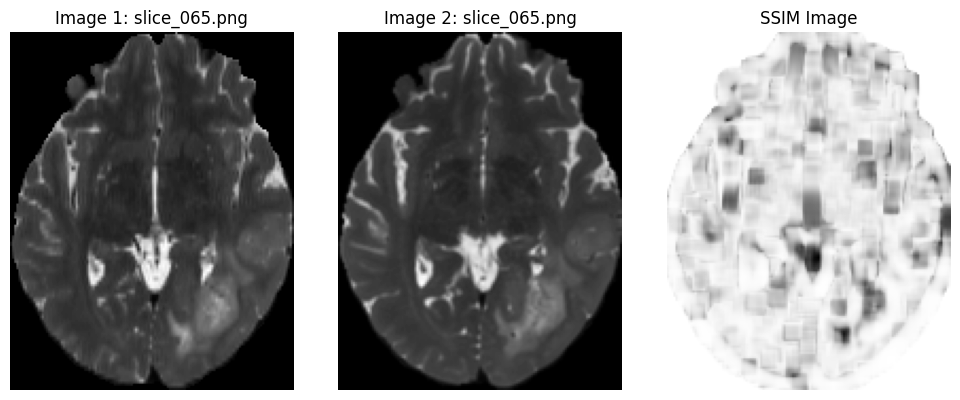

SSIM index for slice_066.png and slice_066.png: 0.8140535452319526


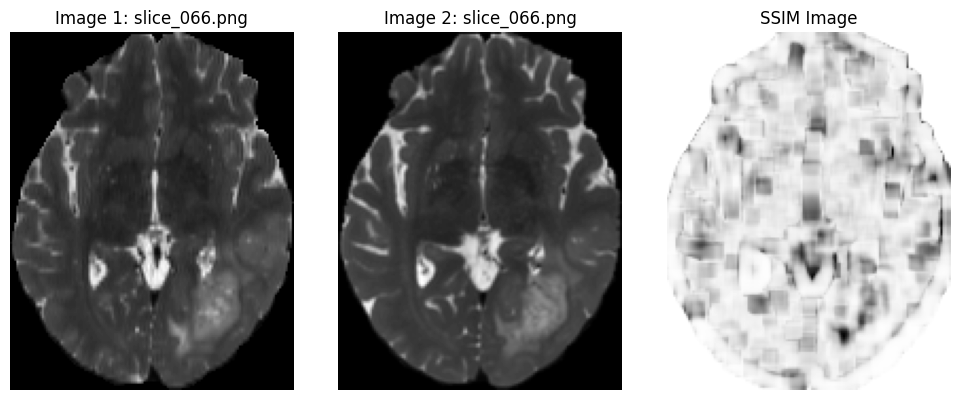

SSIM index for slice_067.png and slice_067.png: 0.8153031190148428


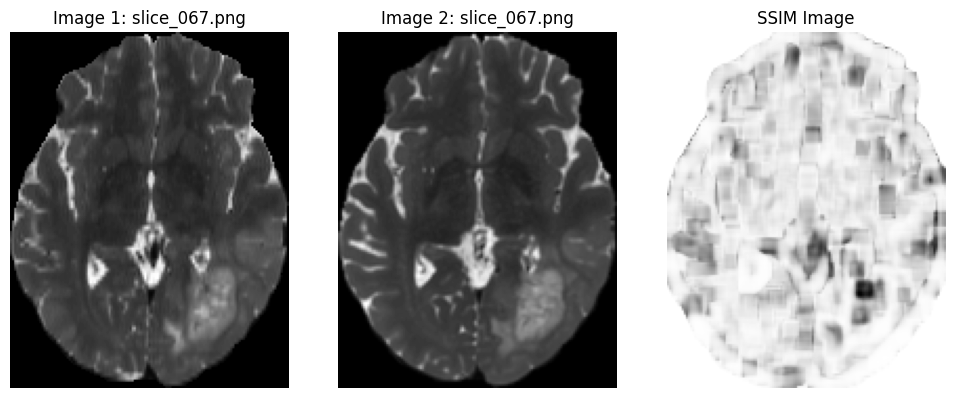

SSIM index for slice_068.png and slice_068.png: 0.8324862923930892


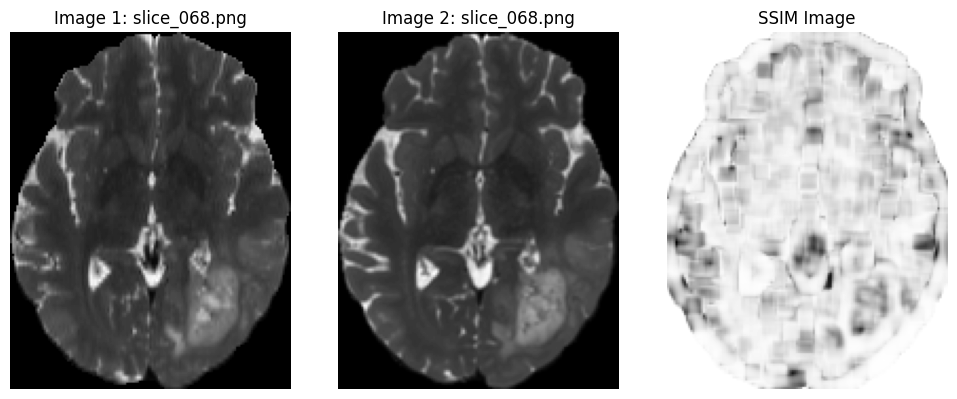

SSIM index for slice_069.png and slice_069.png: 0.8332863910618781


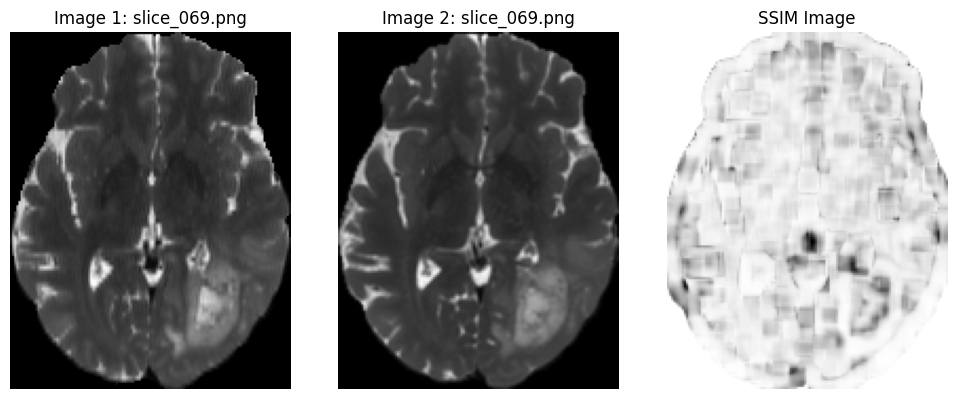

SSIM index for slice_070.png and slice_070.png: 0.8359486989801912


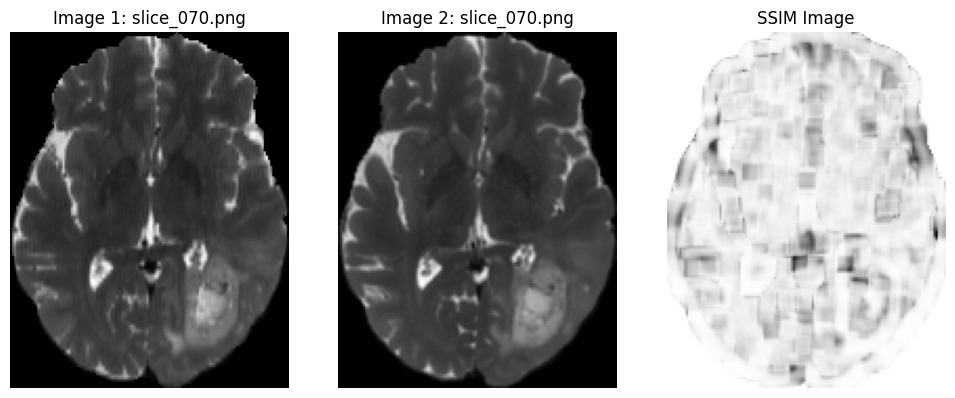

SSIM index for slice_071.png and slice_071.png: 0.8479504638447456


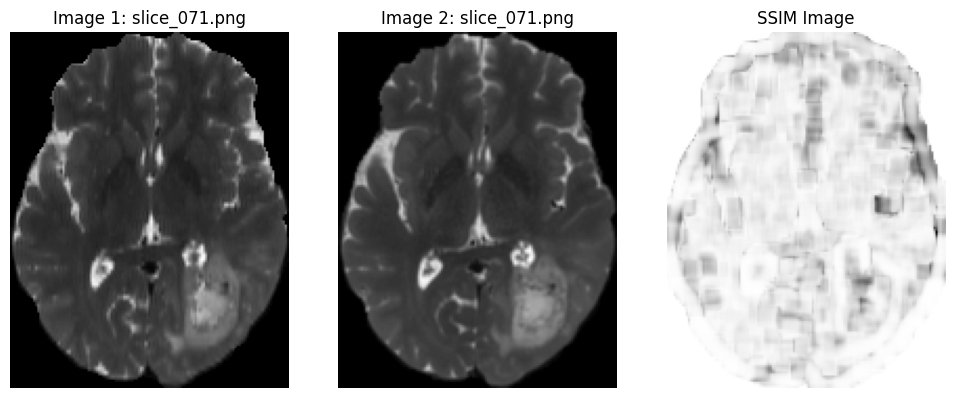

SSIM index for slice_072.png and slice_072.png: 0.8649097830171193


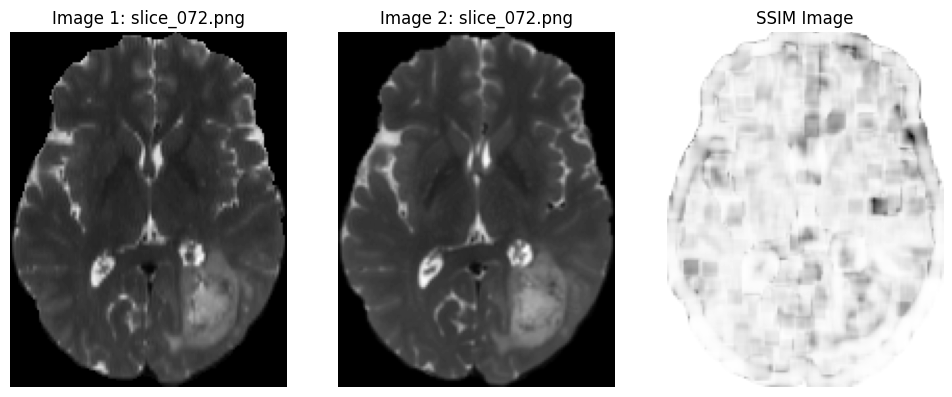

SSIM index for slice_073.png and slice_073.png: 0.8997992377957982


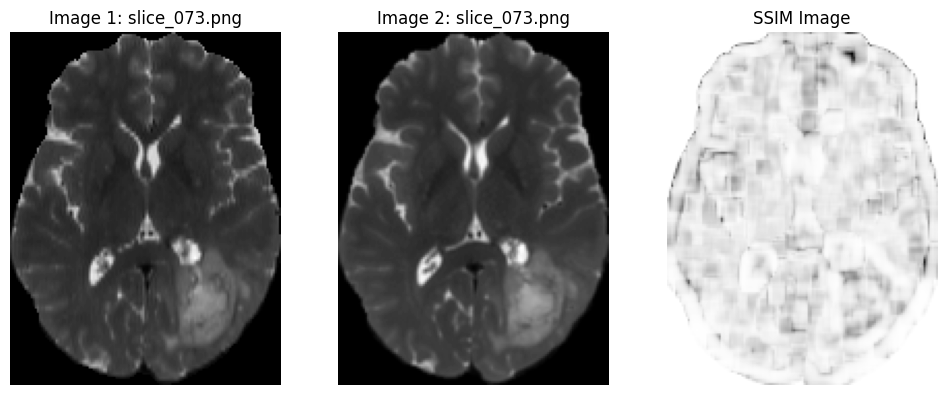

SSIM index for slice_074.png and slice_074.png: 0.9041389192529455


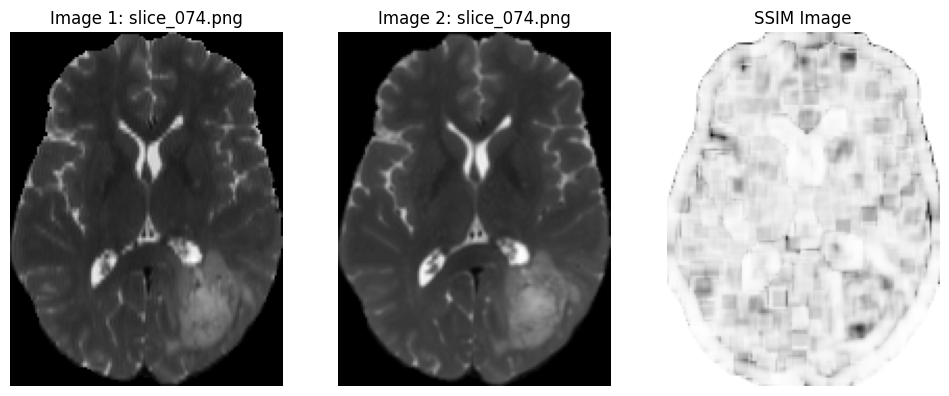

SSIM index for slice_075.png and slice_075.png: 0.9050267030555046


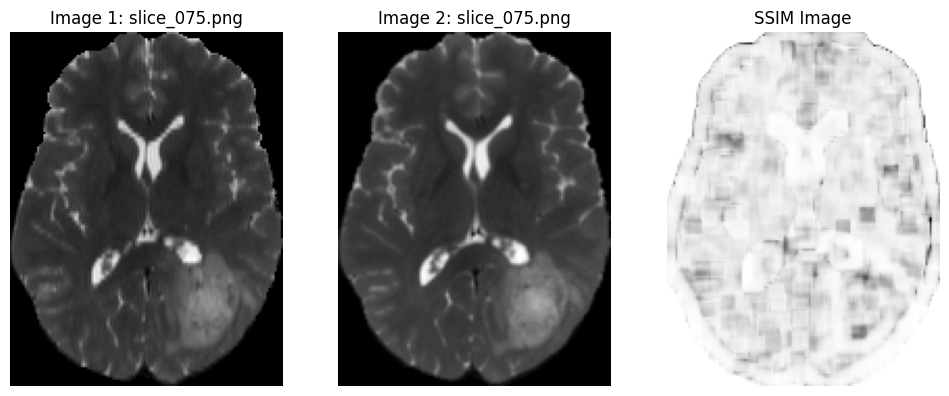

SSIM index for slice_076.png and slice_076.png: 0.9129801550621597


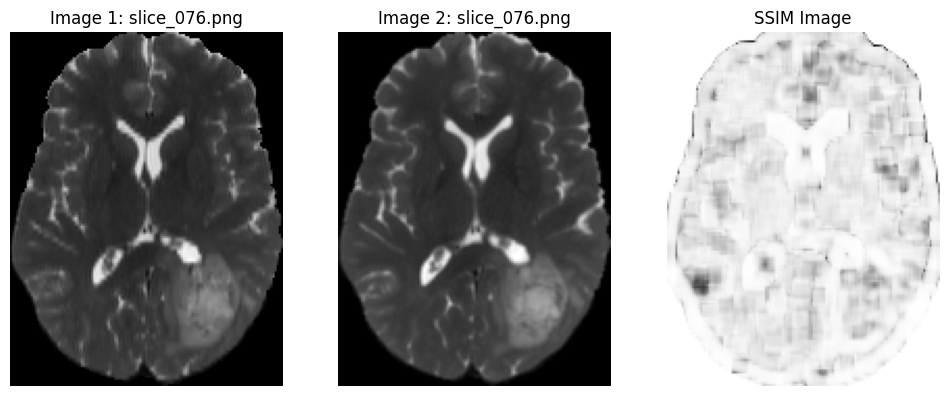

SSIM index for slice_077.png and slice_077.png: 0.9099369186962704


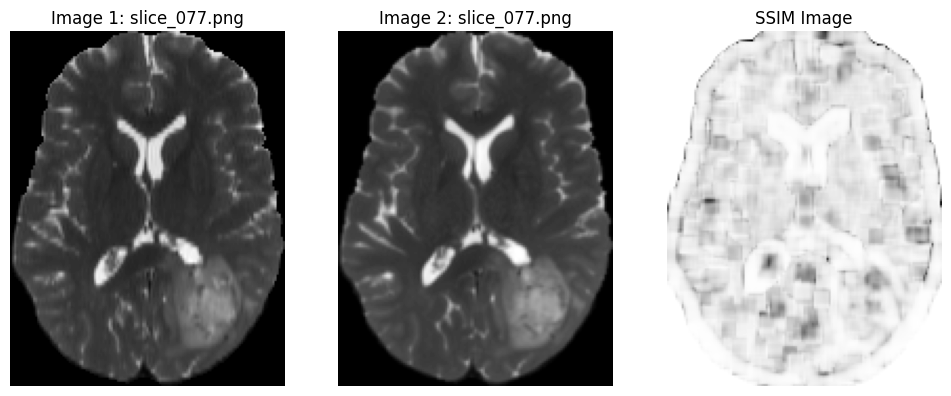

SSIM index for slice_078.png and slice_078.png: 0.8712224862151519


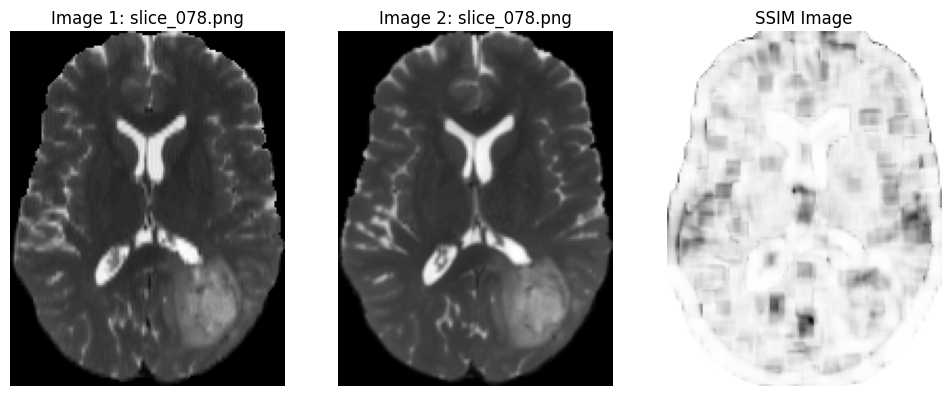

SSIM index for slice_079.png and slice_079.png: 0.8993557095655033


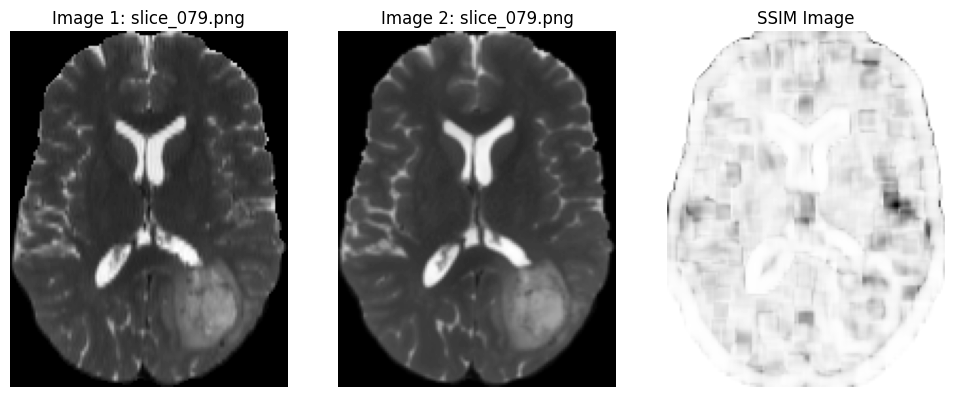

SSIM index for slice_080.png and slice_080.png: 0.9010458206551086


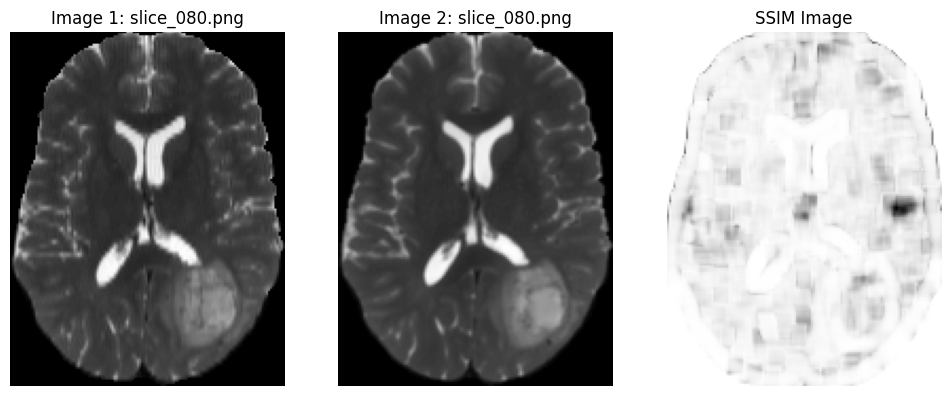

SSIM index for slice_081.png and slice_081.png: 0.908210981635808


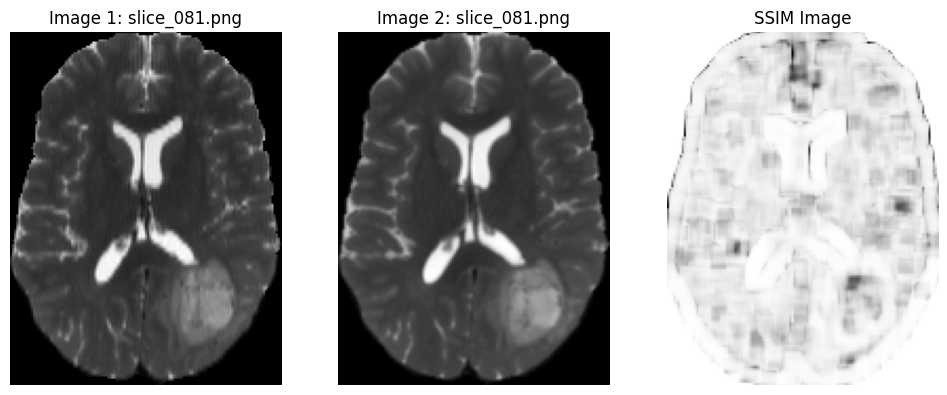

SSIM index for slice_082.png and slice_082.png: 0.9103202265555193


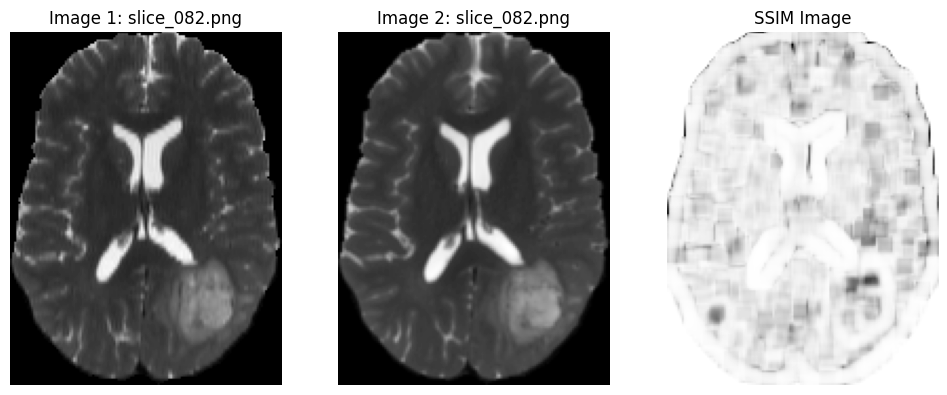

SSIM index for slice_083.png and slice_083.png: 0.9059992030621854


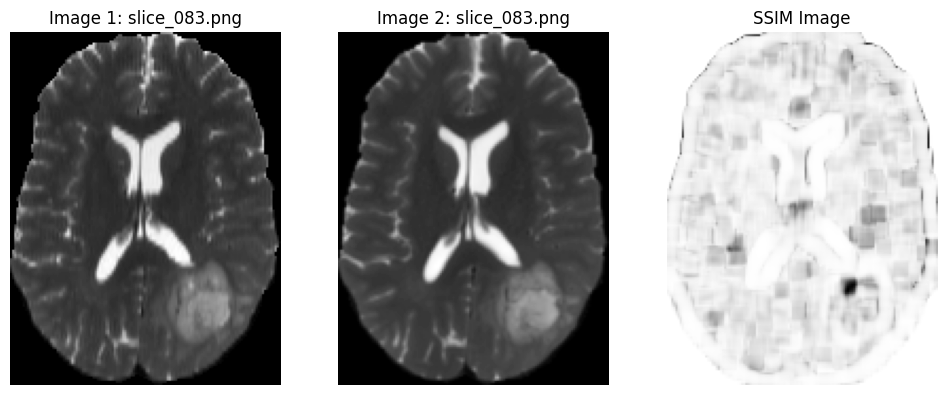

SSIM index for slice_084.png and slice_084.png: 0.9076873628321687


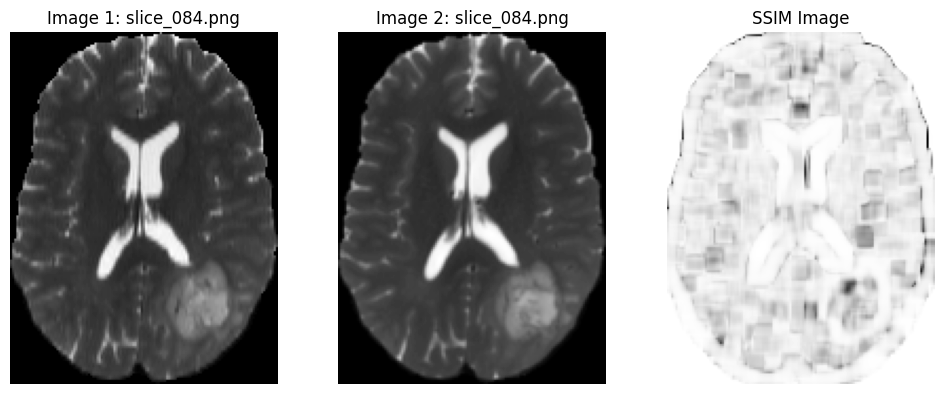

Average SSIM index for the middle 20 images: 0.8741272358598833


In [286]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.metrics import structural_similarity as ssim

num_middle_frames = 20

# Function to load and convert an image to grayscale
def load_image_grayscale(image_path):
    image = io.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 4:  # Check if the image is RGBA
        image = color.rgba2rgb(image)  # Convert RGBA to RGB
    if len(image.shape) == 3:  # Check if the image is RGB
        image = color.rgb2gray(image)
    return image

# Paths to the folders containing the images
folder1_path = Converted_Target_png_from_nii_croped_path_path
folder2_path = Generated_resized_results_path

# List of image filenames in both folders
image_files1 = sorted(os.listdir(folder1_path))
image_files2 = sorted(os.listdir(folder2_path))

# Ensure both folders contain the same number of images
assert len(image_files1) == len(image_files2), "Folders must contain the same number of images."

# Calculate the start and end indices for the middle 30 images
num_images = len(image_files1)
start_index = (num_images - num_middle_frames) // 2
end_index = start_index + num_middle_frames

# Initialize a list to store SSIM indices
ssim_indices = []

# Loop through each pair of middle 30 images and calculate SSIM
for img_file1, img_file2 in zip(image_files1[start_index:end_index], image_files2[start_index:end_index]):
    image1_path = os.path.join(folder1_path, img_file1)
    image2_path = os.path.join(folder2_path, img_file2)
    
    # Load images
    image1 = load_image_grayscale(image1_path)
    image2 = load_image_grayscale(image2_path)

    # Determine the data range
    data_range = max(image1.max(), image2.max())
    
    # Calculate SSIM between the two images
    ssim_index, ssim_image = ssim(image1, image2, data_range=data_range, full=True)
    
    # Append SSIM index to the list
    ssim_indices.append(ssim_index)
    
    # Print SSIM index
    print(f"SSIM index for {img_file1} and {img_file2}: {ssim_index}")
    
    # Display the images and the SSIM comparison image
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    ax = axes.ravel()

    ax[0].imshow(image1.T, cmap=plt.cm.gray)
    ax[0].set_title(f'Image 1: {img_file1}')

    ax[1].imshow(image2.T, cmap=plt.cm.gray)
    ax[1].set_title(f'Image 2: {img_file2}')

    ax[2].imshow(ssim_image.T, cmap=plt.cm.gray)
    ax[2].set_title('SSIM Image')

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()

# Calculate and print the average SSIM index
average_ssim = np.mean(ssim_indices)
print(f"Average SSIM index for the middle {num_middle_frames} images: {average_ssim}")


## **PSNR**

In [287]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage import io, color
# from skimage.metrics import peak_signal_noise_ratio as psnr

# # Function to load and convert an image to grayscale
# def load_image_grayscale(image_path):
#     image = io.imread(image_path)
#     if len(image.shape) == 3 and image.shape[2] == 4:  # Check if the image is RGBA
#         image = color.rgba2rgb(image)  # Convert RGBA to RGB
#     if len(image.shape) == 3:  # Check if the image is RGB
#         image = color.rgb2gray(image)
#     return image

# # Paths to the folders containing the images
# folder1_path = Converted_Target_png_from_nii_croped_path_path
# folder2_path = Generated_resized_results_path

# # Number of middle frames to consider
# num_middle_frames = 30

# # List of image filenames in both folders
# image_files1 = sorted(os.listdir(folder1_path))
# image_files2 = sorted(os.listdir(folder2_path))

# # Ensure both folders contain the same number of images
# assert len(image_files1) == len(image_files2), "Folders must contain the same number of images."

# # Calculate the start and end indices for the middle 30 images
# num_images = len(image_files1)
# start_index = (num_images - num_middle_frames) // 2
# end_index = start_index + num_middle_frames

# # Initialize a list to store PSNR values
# psnr_values = []

# # Loop through each pair of middle 30 images and calculate PSNR
# for img_file1, img_file2 in zip(image_files1[start_index:end_index], image_files2[start_index:end_index]):
#     image1_path = os.path.join(folder1_path, img_file1)
#     image2_path = os.path.join(folder2_path, img_file2)
    
#     # Load images
#     image1 = load_image_grayscale(image1_path)
#     image2 = load_image_grayscale(image2_path)

#     # Normalize images to the range [0, 1]
#     image1 = image1 / 255.0
#     image2 = image2 / 255.0

#     # Calculate PSNR between the two images
#     psnr_value = psnr(image1, image2, data_range=1.0)  # Assuming images are now in the range [0, 1]
    
#     # Append PSNR value to the list
#     psnr_values.append(psnr_value)
    
#     # Print PSNR value
#     print(f"PSNR for {img_file1} and {img_file2}: {psnr_value}")

# # Calculate and print the average PSNR
# average_psnr = np.mean(psnr_values)
# print(f"Average PSNR for the middle {num_middle_frames} images: {average_psnr}")

In [290]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.metrics import peak_signal_noise_ratio as psnr

# Function to load and convert an image to grayscale
def load_image_grayscale(image_path):
    image = io.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 4:  # Check if the image is RGBA
        image = color.rgba2rgb(image)  # Convert RGBA to RGB
    if len(image.shape) == 3:  # Check if the image is RGB
        image = color.rgb2gray(image)
    return image

# Paths to the folders containing the images
folder1_path = Converted_Target_png_from_nii_croped_path_path
folder2_path = Generated_resized_results_path

# List of image filenames in both folders
image_files1 = sorted(os.listdir(folder1_path))
image_files2 = sorted(os.listdir(folder2_path))

# Ensure both folders contain the same number of images
assert len(image_files1) == len(image_files2), "Folders must contain the same number of images."

# Calculate the start and end indices for the middle 30 images
num_images = len(image_files1)
start_index = (num_images - num_middle_frames) // 2
end_index = start_index + num_middle_frames

# Initialize a list to store PSNR values
psnr_values = []

# Loop through each pair of middle 30 images and calculate PSNR
for img_file1, img_file2 in zip(image_files1[start_index:end_index], image_files2[start_index:end_index]):
    image1_path = os.path.join(folder1_path, img_file1)
    image2_path = os.path.join(folder2_path, img_file2)
    
    # Load images
    image1 = load_image_grayscale(image1_path)
    image2 = load_image_grayscale(image2_path)

    # Calculate PSNR between the two images
    psnr_value = psnr(image1, image2, data_range=image1.max() - image1.min())
    
    # Append PSNR value to the list
    psnr_values.append(psnr_value)
    
    # Print PSNR value
    print(f"PSNR for {img_file1} and {img_file2}: {psnr_value}")

# Calculate and print the average PSNR
average_psnr = np.mean(psnr_values)
print(f"Average PSNR for the middle {num_middle_frames} images: {average_psnr}")


PSNR for slice_065.png and slice_065.png: 23.389136523127128
PSNR for slice_066.png and slice_066.png: 23.571470436152595
PSNR for slice_067.png and slice_067.png: 23.31481623533184
PSNR for slice_068.png and slice_068.png: 23.914320841141155
PSNR for slice_069.png and slice_069.png: 23.885433106587918
PSNR for slice_070.png and slice_070.png: 23.853217205099927
PSNR for slice_071.png and slice_071.png: 24.581403968648196
PSNR for slice_072.png and slice_072.png: 25.510814390273907
PSNR for slice_073.png and slice_073.png: 27.764393129867628
PSNR for slice_074.png and slice_074.png: 28.267358553504714
PSNR for slice_075.png and slice_075.png: 28.249815505555567
PSNR for slice_076.png and slice_076.png: 28.564449264003503
PSNR for slice_077.png and slice_077.png: 27.51075117231522
PSNR for slice_078.png and slice_078.png: 26.29533206076575
PSNR for slice_079.png and slice_079.png: 27.789690361016422
PSNR for slice_080.png and slice_080.png: 28.509509291569334
PSNR for slice_081.png and 

## **MAE**

In [291]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from sklearn.metrics import mean_absolute_error

# Function to load and convert an image to grayscale
def load_image_grayscale(image_path):
    image = io.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 4:  # Check if the image is RGBA
        image = color.rgba2rgb(image)  # Convert RGBA to RGB
    if len(image.shape) == 3:  # Check if the image is RGB
        image = color.rgb2gray(image)
    return image

# Paths to the folders containing the images
folder1_path = Converted_Target_png_from_nii_croped_path_path
folder2_path = Generated_resized_results_path

# List of image filenames in both folders
image_files1 = sorted(os.listdir(folder1_path))
image_files2 = sorted(os.listdir(folder2_path))

# Ensure both folders contain the same number of images
assert len(image_files1) == len(image_files2), "Folders must contain the same number of images."

# Calculate the start and end indices for the middle 30 images
num_images = len(image_files1)
start_index = (num_images - num_middle_frames) // 2
end_index = start_index + num_middle_frames

# Initialize a list to store MAE values
mae_values = []

# Loop through each pair of middle 30 images and calculate MAE
for img_file1, img_file2 in zip(image_files1[start_index:end_index], image_files2[start_index:end_index]):
    image1_path = os.path.join(folder1_path, img_file1)
    image2_path = os.path.join(folder2_path, img_file2)
    
    # Load images
    image1 = load_image_grayscale(image1_path)
    image2 = load_image_grayscale(image2_path)

    # Calculate MAE between the two images
    mae_value = mean_absolute_error(image1.flatten(), image2.flatten())
    
    # Append MAE value to the list
    mae_values.append(mae_value)
    
    # Print MAE value
    print(f"MAE for {img_file1} and {img_file2}: {mae_value}")

# Calculate and print the average MAE
average_mae = np.mean(mae_values)
print(f"Average MAE for the middle {num_middle_frames} images: {average_mae}")


MAE for slice_065.png and slice_065.png: 0.031236785096446066
MAE for slice_066.png and slice_066.png: 0.03098846179821394
MAE for slice_067.png and slice_067.png: 0.03142614321270304
MAE for slice_068.png and slice_068.png: 0.02980301432313816
MAE for slice_069.png and slice_069.png: 0.031201568138934176
MAE for slice_070.png and slice_070.png: 0.028811821942399254
MAE for slice_071.png and slice_071.png: 0.027842096590958366
MAE for slice_072.png and slice_072.png: 0.028410551662955117
MAE for slice_073.png and slice_073.png: 0.025190927225762855
MAE for slice_074.png and slice_074.png: 0.02561469311568363
MAE for slice_075.png and slice_075.png: 0.025501113781839637
MAE for slice_076.png and slice_076.png: 0.022021359958442288
MAE for slice_077.png and slice_077.png: 0.026731462267367764
MAE for slice_078.png and slice_078.png: 0.02688043192343562
MAE for slice_079.png and slice_079.png: 0.02433054646795105
MAE for slice_080.png and slice_080.png: 0.019602097249156073
MAE for slice_